# Step 1: Import Libraries and Download Data

In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Download historical stock data
data = yf.download('AAPL', start='2015-01-01', end='2025-01-01')

# Display basic info
print(data.tail())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2024-12-24  257.916443  257.926411  255.009620  255.209412  23234700
2024-12-26  258.735504  259.814335  257.347047  257.906429  27237100
2024-12-27  255.309296  258.415896  252.782075  257.546826  42355300
2024-12-30  251.923019  253.221595  250.474615  251.952985  35557500
2024-12-31  250.144974  253.001833  249.156056  252.162760  39480700


# Step 2: Feature Engineering and Target Variable

In [26]:
# Create technical indicators
data['Return'] = data['Close'].pct_change()
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['Volatility'] = data['Return'].rolling(window=10).std()

# Drop missing values
data.dropna(inplace=True)

# Create binary target: 1 if next day is up, 0 otherwise
data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)

print(data[['Return', 'MA10', 'MA50', 'Volatility', 'Target']].tail())

Price         Return        MA10        MA50 Volatility Target
Ticker                                                        
Date                                                          
2024-12-24  0.011478  251.014017  235.564016   0.011168      1
2024-12-26  0.003176  252.265639  236.071997   0.010694      0
2024-12-27 -0.013242  253.027800  236.552763   0.012133      0
2024-12-30 -0.013263  253.434354  236.958419   0.013197      0
2024-12-31 -0.007058  253.372423  237.271641   0.012947      0


# Step 3: Preparing Data for Neural Networks

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = ['Return', 'MA10', 'MA50', 'Volatility']
X = data[features]
y = data['Target']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Step 4: Building a Neural Network with Keras

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define the model using an explicit Input layer
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary output
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5395 - loss: 0.6930 - val_accuracy: 0.5152 - val_loss: 0.6945
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5266 - loss: 0.6925 - val_accuracy: 0.5152 - val_loss: 0.6918
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5483 - loss: 0.6894 - val_accuracy: 0.5202 - val_loss: 0.6930
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5448 - loss: 0.6883 - val_accuracy: 0.5152 - val_loss: 0.6912
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5331 - loss: 0.6908 - val_accuracy: 0.5202 - val_loss: 0.6909
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5349 - loss: 0.6901 - val_accuracy: 0.5253 - val_loss: 0.6943
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5344 - loss: 0.6892 - val_accuracy: 0.5404 - val_loss: 0.6886
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5443 - loss: 0.6900 - val_accuracy: 0.5404 - val_loss:

# Step 5: Model Evaluation

In [35]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Predict on test set
predictions = (model.predict(X_test) > 0.5).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5139 - loss: 0.6987 
Test Accuracy: 0.51
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[[128  90]
 [150 126]]
              precision    recall  f1-score   support

           0       0.46      0.59      0.52       218
           1       0.58      0.46      0.51       276

    accuracy                           0.51       494
   macro avg       0.52      0.52      0.51       494
weighted avg       0.53      0.51      0.51       494



# Step 6: Visualizing Model Performance

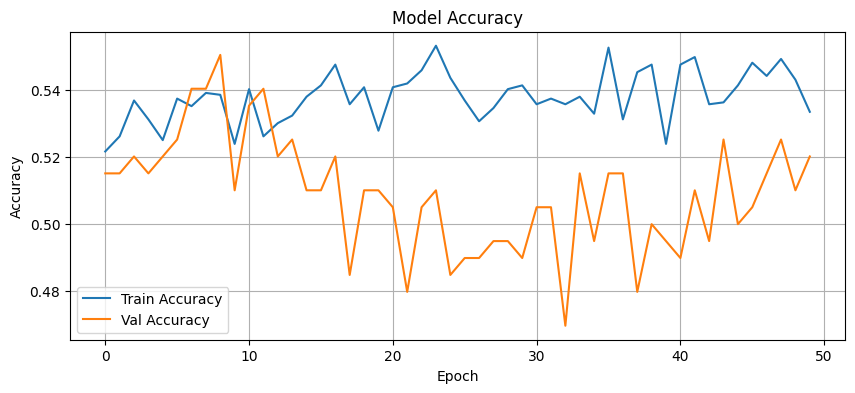

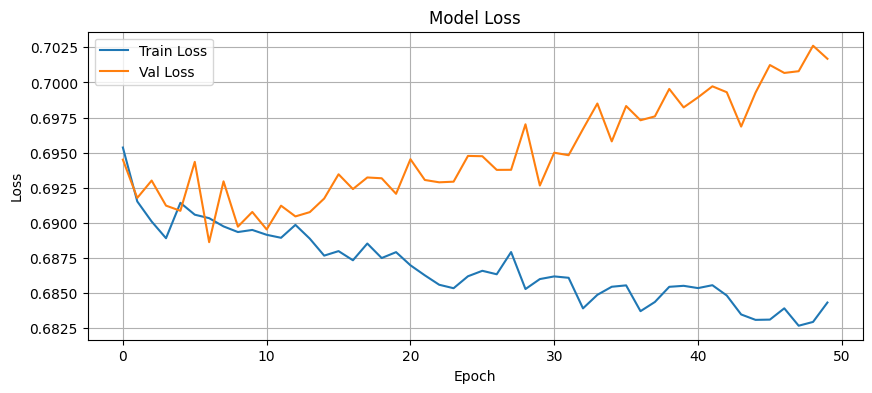

In [38]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()